#Algoritmo de RandomForest Regresion

# Librerías necesarias

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree as tr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# 0.Prepraración de Datos (Load) desde Google Drive
*Si tu ambiente es local comenta el código a continuación*

In [2]:
!pip install -q pydrive

    100% |████████████████████████████████| 993kB 21.0MB/s 


In [0]:
from google.colab import auth
auth.authenticate_user()

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load hour.csv
myfile = drive.CreateFile({'id': '1219Iw0Wb5eRUUDfUR97vX72TtXFVhTdb'})
myfile.GetContentFile('hour.csv')

# Load day.csv
myfile2 = drive.CreateFile({'id': '1k18ZgnLKgv-cusgvmEcJrXv29rrqJkfi'})
myfile2.GetContentFile('day.csv')

# Leer Dataset hour.csv

In [4]:
data_hour = pd.read_csv('hour.csv')
data_hour.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


# Leer Dataset day.csv
** Este dataset no se tomará en cuenta pues el dataset hour.csv es mas completo**

In [5]:
data_day = pd.read_csv('day.csv')
data_day.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


#1.Análisis de Datos
**Análisis de Datos Missing y Outliers**

# 1.1.Buscamos valores missing (Nan), si  existieren

In [6]:
# Contar el número de valores no NaN en cada columna
data_hour.count()
# Todos los datos son parejos

instant       17379
dteday        17379
season        17379
yr            17379
mnth          17379
hr            17379
holiday       17379
weekday       17379
workingday    17379
weathersit    17379
temp          17379
atemp         17379
hum           17379
windspeed     17379
casual        17379
registered    17379
cnt           17379
dtype: int64

In [7]:
# contamos los valores Nan en cada columna
data_hour.isnull().sum()
## otra forma de hacer lo mismo
# data_hour.apply(lambda i: sum(i.isnull()))

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#1.2.Buscamos outliers (atípicos), si existieren

---

**Comparamos mean (media) y median (mediana)**
**Si los valores por cada característica difieren 'demasiado', **
**entonces existen valores atípicos en nuestro dataset **
**que necesitan set tratados, para este ejemplo los outliers estan**
**estan en 'casual' y 'registered'**

In [8]:
data_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [9]:
data_hour.median()

instant       8690.0000
season           3.0000
yr               1.0000
mnth             7.0000
hr              12.0000
holiday          0.0000
weekday          3.0000
workingday       1.0000
weathersit       1.0000
temp             0.5000
atemp            0.4848
hum              0.6300
windspeed        0.1940
casual          17.0000
registered     115.0000
cnt            142.0000
dtype: float64

In [0]:
# Hago una copia del dataset, para realizar el análisis 
data_hour2 = data_hour.copy()
#type(data_hour2)

In [11]:
## Realizamos el tratamiento para 'registered'
#Calculamos los cuantiles:
# Cuartil 1  es de 25%
# Cuartil 2  es de 50%
# Cuartil 3  es de 75%
q25=np.percentile(data_hour2[['registered']], 25)
q75=np.percentile(data_hour2[['registered']], 75)
RIC=q75-q25
LI=q25-1.5*RIC
LS=q75+1.5*RIC
#Verificamos los cortes:
# LI: Limite Inferior
# SL: Limite superior
# Los valores que estan fuera de este rango, se lo considera valores atipicos
print(LI,LS)

-245.0 499.0


In [12]:
# Determinando el total de valores atípicos para 'registered'.

MIN=data_hour2[['registered']].min()
MAX=data_hour2[['registered']].max()
#print(MIN,MAX)

# df_LI: Dataset con los datos que cumplen el criterio de LI.
df_LI=data_hour2[data_hour2['registered']>=LI]
# df_LS: Dataset con los datos que cumplen el criterio de LS.
# Al utilizar el dataframe, restara el valor total con los atipicos
df_LS=data_hour2[data_hour2['registered']<=LS]

v_atipico_inferior_registered = data_hour2[['registered']].count() - df_LI[['registered']].count()
v_atipico_superior_registered = data_hour2[['registered']].count() - df_LS[['registered']].count()
print("Valores atípicos encontrados para registered: ")
print("Límite inferior: " + str(v_atipico_inferior_registered))
print("Límite superor: " + str(v_atipico_superior_registered))

Valores atípicos encontrados para registered: 
Límite inferior: registered    0
dtype: int64
Límite superor: registered    680
dtype: int64


In [0]:
# Se crea una nueva columna y los valores que son "atipicos" son reemplazos con
#el cuantil 3
data_hour2['registered2']=data_hour2['registered'].where(data_hour2['registered']<=LS,q75)

In [14]:
## Realizamos el mismo análisis para la característica "casual"
q25=np.percentile(data_hour2[['casual']], 25)
q75=np.percentile(data_hour2[['casual']], 75)
RIC=q75-q25
LI=q25-1.5*RIC
LS=q75+1.5*RIC
print(LI,LS)

-62.0 114.0


In [15]:
# Determinando el total de valores atípicos para 'registered'.

MIN=data_hour2[['casual']].min()
MAX=data_hour2[['casual']].max()
#print(MIN,MAX)

# df_LI: Dataset con los datos que cumplen el criterio de LI.
df_LI=data_hour2[data_hour2['casual']>=LI]
# df_LS: Dataset con los datos que cumplen el criterio de LS.
# Al utilizar el dataframe, restara el valor total con los atipicos
df_LS=data_hour2[data_hour2['casual']<=LS]

v_atipico_inferior_casual = data_hour2[['casual']].count() - df_LI[['casual']].count()
v_atipico_superior_casual = data_hour2[['casual']].count() - df_LS[['casual']].count()
print("Valores atípicos encontrados para casual: ")
print("Límite inferior: " + str(v_atipico_inferior_casual))
print("Límite superor: " + str(v_atipico_superior_casual))

Valores atípicos encontrados para casual: 
Límite inferior: casual    0
dtype: int64
Límite superor: casual    1192
dtype: int64


In [0]:
# Se crea una nueva columna para casual. Para los datos atipicos son reemplazado
# con el cuantil 3
data_hour2['casual2'] = data_hour2['casual'].where(data_hour2['casual']<=LS,q75)

In [17]:
## Volmemos a realizar el análisis, pues ahora los valores de mean y median
## de casual y registered ya no estan tan 'alejados'
data_hour2.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,registered2,casual2
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,137.728580,26.631970
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,116.606252,27.206421
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,34.000000,4.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,115.000000,17.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,220.000000,48.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,499.000000,114.000000


In [18]:
data_hour2.median()

instant        8690.0000
season            3.0000
yr                1.0000
mnth              7.0000
hr               12.0000
holiday           0.0000
weekday           3.0000
workingday        1.0000
weathersit        1.0000
temp              0.5000
atemp             0.4848
hum               0.6300
windspeed         0.1940
casual           17.0000
registered      115.0000
cnt             142.0000
registered2     115.0000
casual2          17.0000
dtype: float64


# 2.Preparación de Datos para entrenamiento

In [0]:
## En primer instancia pensé en eliminar dteday
#data_hour = data_hour.drop(['dteday'], axis=1)

## Reévaluo la idea y mejor recupero el día del string '2012-12-31'
## Pues el dataset no cuenta con una columna día, para el resto del date si

from datetime import datetime

for indice in range(len(data_hour2)):
  dt = datetime.strptime(data_hour2.dteday[indice], '%Y-%m-%d')
  new_value = dt.day
  data_hour2.loc[indice, 'dteday'] = new_value

In [0]:
## Separamos en atributos y etiquetas
## Etiquetas, labels son los valores que vamos a predecir.
## No considero previamente  instan ya que es el index del dataset

X = data_hour2[['season','dteday','yr','mnth','hr','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','casual2','registered2']].values
#X = data_hour.iloc[:,1:16].values
y = data_hour2['cnt']
#len(X), len(y)
#print(X)
#print(y)

# Encabezados para posterior uso sin la variable cnt
#feature_list = list(data_hour.iloc[:,1:16])
feature_list = ['season','dteday','yr','mnth','hr','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','casual2','registered2']

In [0]:
## Finalmente, dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

In [0]:
## Este codigo aplico en el caso que los datos no estuvieran escalados.
## <<Valores en diferentes medidas>>
## Aunque en Randomforest no es importante.
##from sklearn.preprocessing import StandardScaler
##sc = StandardScaler()  
##X_train = sc.fit_transform(X_train)  
##X_test = sc.transform(X_test)  

In [23]:
# Visualizo la forma actual del dataset
print(X_train.shape, y_train.shape)

(12165, 15) (12165,)


# Entrenamiento
**Entrenamiento del modelo con parametros búsqueda por medio del método de validación cruzada**

In [0]:
## Búsqueda de los mejores hiperparametros con Grid Search with Cross Validation
from sklearn.model_selection import GridSearchCV

## Create the parameter grid based on the results of random search 
#### This will try out 3 * 2 * 2 * 3 * 3 * 2 = 72 ##
# max_depth = número máximo de niveles en cada árbol de decisión
# max_features = número máximo de funciones consideradas para dividir un nodo
# min_samples_leaf = número mínimo de puntos de datos permitidos en un nodo hoja
# min_samples_split = número mínimo de puntos de datos colocados en un nodo antes de dividir el nodo
# n_estimators = número de árboles en el foreset

parametros = {'bootstrap': [True],
    'max_depth': [80, 90, 100], # 110
    'max_features': [2, 3, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]#, 1000
}

# Create a based model
# n_jobs = Numero de trabajos en paralelo, -1 usa todos los procesadores.
# cv = Determina la estrategia de división de validación cruzada - KFOLD
# verbose = Controla la verbosidad: cuanto más alto, más mensajes
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = parametros, 
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 2)

In [25]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Visualizamos los mejores parametros, luego de la validación cruzada.
grid_search.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 17.4min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

# Evaluación o Test

In [0]:
# Función para evaluar nuestro mejor modelo con los mejores hiperparametros.
# Probamos el modelo  entrenado en datos de prueba
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    r2 = metrics.r2_score(y_train,predictions)
    # Display the performance metrics
    print('Model Performance')
    print('R2 Score: {:0.2f} %.'.format(r2*100))
    # Los errores mas bajos son mejores
    print('Mean Absolute Error (MAE): ', round(np.mean(errors), 2), 'degrees.')
    print('Accuracy: {:0.2f} %.'.format(accuracy)) 
    #r2 score -- hacer
    return accuracy, predictions

In [27]:
best_grid = grid_search.best_estimator_
grid_accuracy, predictions = evaluate(best_grid, X_train, y_train)

Model Performance
R2 Score: 99.45 %.
Mean Absolute Error (MAE):  5.42 degrees.
Accuracy: 95.57 %.


# Importancia de las Variables
Las variables (características) con valor 0, pudimos haberlas desechado, pues no aportaban al entrenamiento de mi modelo.

In [28]:
# Get numerical feature importances
importances = list(best_grid.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importancia: {}'.format(*pair)) for pair in feature_importances];

Variable: registered2          Importancia: 0.59
Variable: casual2              Importancia: 0.2
Variable: hr                   Importancia: 0.11
Variable: yr                   Importancia: 0.02
Variable: temp                 Importancia: 0.02
Variable: atemp                Importancia: 0.02
Variable: workingday           Importancia: 0.01
Variable: hum                  Importancia: 0.01
Variable: season               Importancia: 0.0
Variable: dteday               Importancia: 0.0
Variable: mnth                 Importancia: 0.0
Variable: holiday              Importancia: 0.0
Variable: weekday              Importancia: 0.0
Variable: weathersit           Importancia: 0.0
Variable: windspeed            Importancia: 0.0


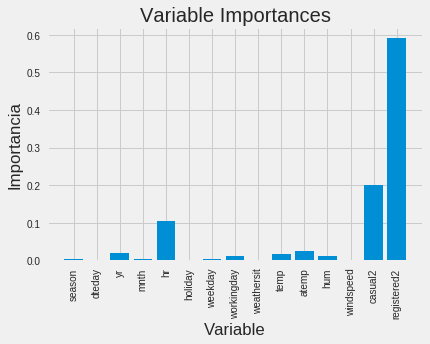

In [29]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importancia'); plt.xlabel('Variable'); plt.title('Variable Importances');

# 3.Randomforest Regresion con los mejores parámetros encontrados

In [0]:
param = grid_search.best_params_

In [31]:
regressor = RandomForestRegressor(bootstrap=param['bootstrap'],
                                 max_depth=param['max_depth'],
                                 max_features=param['max_features'],
                                 min_samples_leaf=param['min_samples_leaf'],
                                 min_samples_split=param['min_samples_split'],
                                 n_estimators=param['n_estimators'])
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [32]:
regressor.score(X_test, y_test)

0.9873546153597148

In [0]:
y_pred = regressor.predict(X_test)

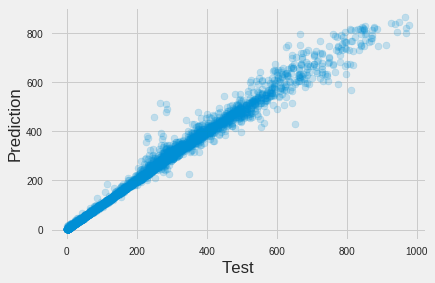

In [34]:
plt.scatter(x=y_test, y=y_pred, alpha=0.2, cmap='rainbow')
plt.xlabel('Test');plt.ylabel('Prediction');plt.title('');
plt.show()